Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
## Using the data by mounting the google drive :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" -d '/content/gdrive/MyDrive/'


Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
   creating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/
   creating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/
   creating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collab

It has a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split=0.2,
    image_size = (img_height,img_width),
    batch_size = batch_size,
    subset = "training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    image_size = (img_height,img_width),
    batch_size = batch_size,
    subset = "validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
train_ds.take(32)

<TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

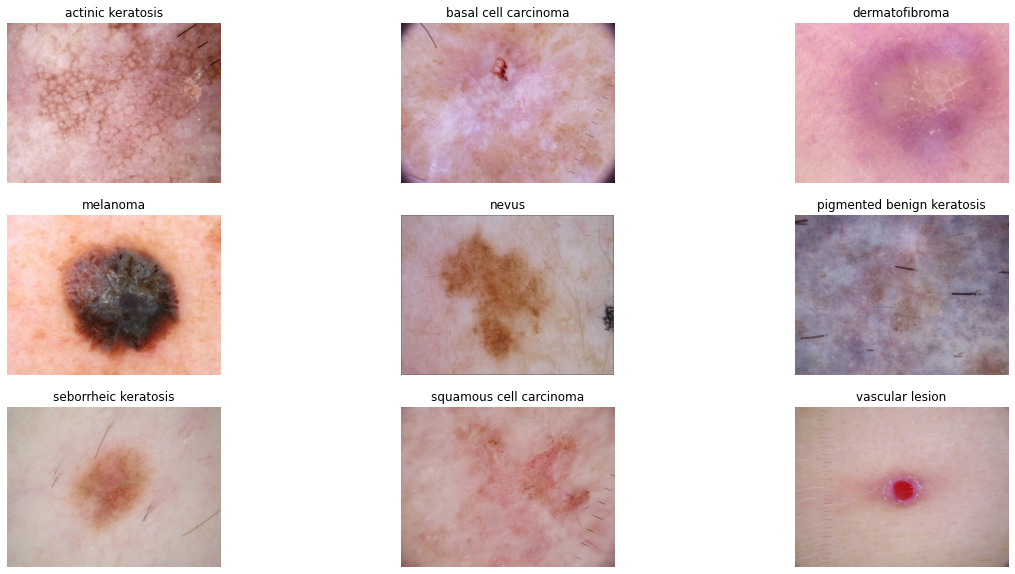

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
for i in range(len(class_names)):
  plt.subplot(3, 3, i+1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[2]))
  plt.imshow(image)
  plt.title(class_names[i])
  plt.axis("off")

## Visualize distribution of classes in the training dataset

In [91]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


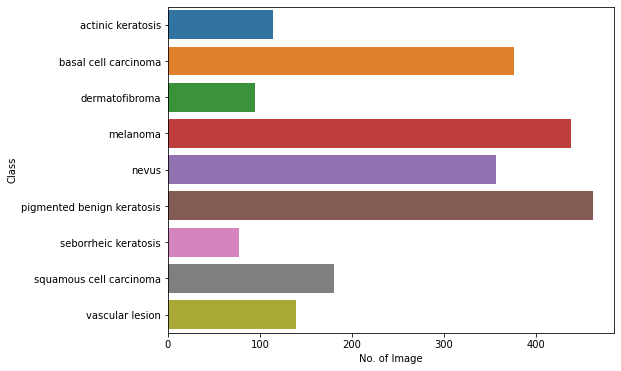

In [15]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer 
classes_nums = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Convolution layer
model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
#Pooling Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. 
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
#Adding another Pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Third Convulation Layer
#Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
model.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2,2)))


#Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
##Flattens the input. Does not affect the batch size.

model.add(layers.Flatten())

#fully connected layer (Dense layer)
model.add(layers.Dense(128, activation="relu"))

# Output neuron
model.add(layers.Dense(classes_nums, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

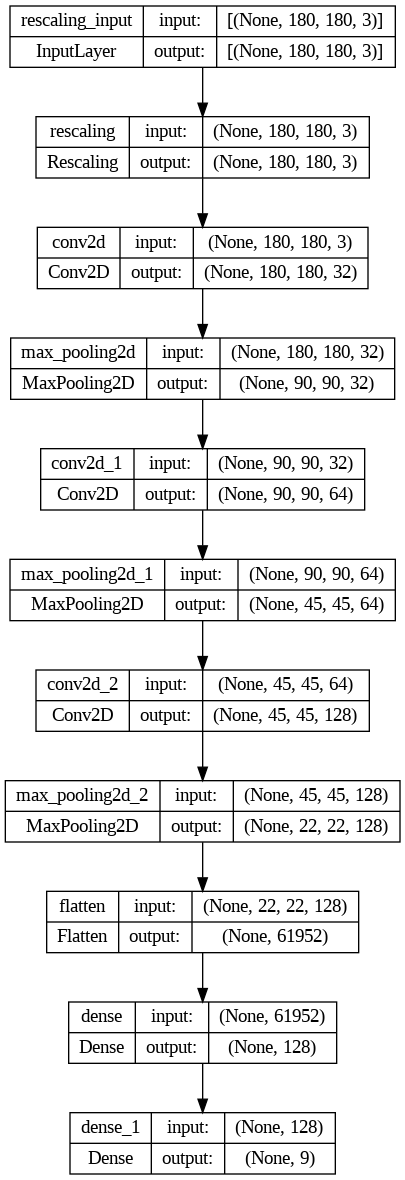

In [20]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 26s 98ms/step - loss: 2.1544 - accuracy: 0.2238 - val_loss: 1.8313 - val_accuracy: 0.3535
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.7638 - accuracy: 0.3817 - val_loss: 1.6111 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5594 - accuracy: 0.4570 - val_loss: 1.6635 - val_accuracy: 0.4497
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3985 - accuracy: 0.5184 - val_loss: 1.6059 - val_accuracy: 0.4251
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3167 - accuracy: 0.5212 - val_loss: 1.5071 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3310 - accuracy: 0.5268 - val_loss: 1.4387 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1888 - accuracy: 0.5893 - val_loss: 1.4048 - val_accuracy: 0.5280
Epoch 8/20
5

### Visualizing training results

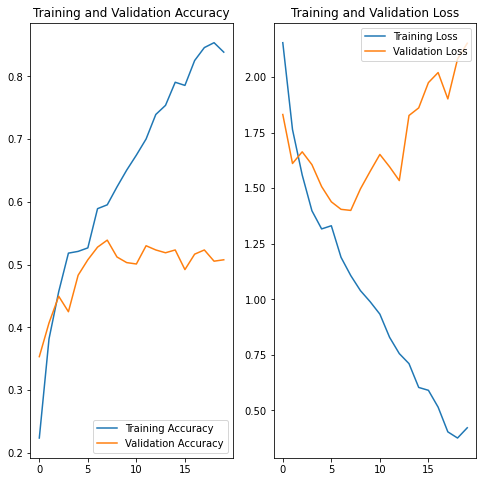

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Inference: As we can see, the model is clearly overfitting, with less than 85% as training accuracies and less than 55% as validation accuracies.


### Write your findings here

In [23]:

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",      # We do the horizontal flip method to augment
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)
     

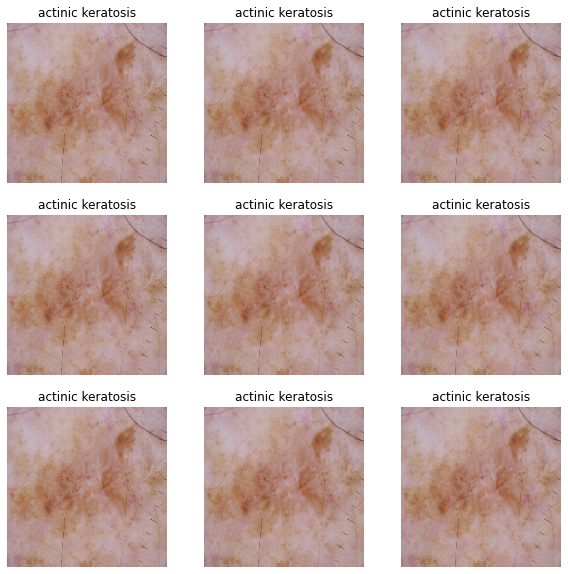

In [43]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[0])


### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
classes_nums = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential()

# Add Augmented data
model.add(data_augmentation)

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Convolution layer
model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
#Pooling Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. 
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
#Adding another Pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Third Convolation Layer
#Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
model.add(layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Let us add some dropouts
model.add(layers.Dropout(0.25)),

#Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
##Flattens the input. Does not affect the batch size.

model.add(layers.Flatten())

#fully connected layer (Dense layer)
model.add(layers.Dense(128, activation="relu"))

# Output neuron
model.add(layers.Dense(classes_nums, activation='softmax'))



### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

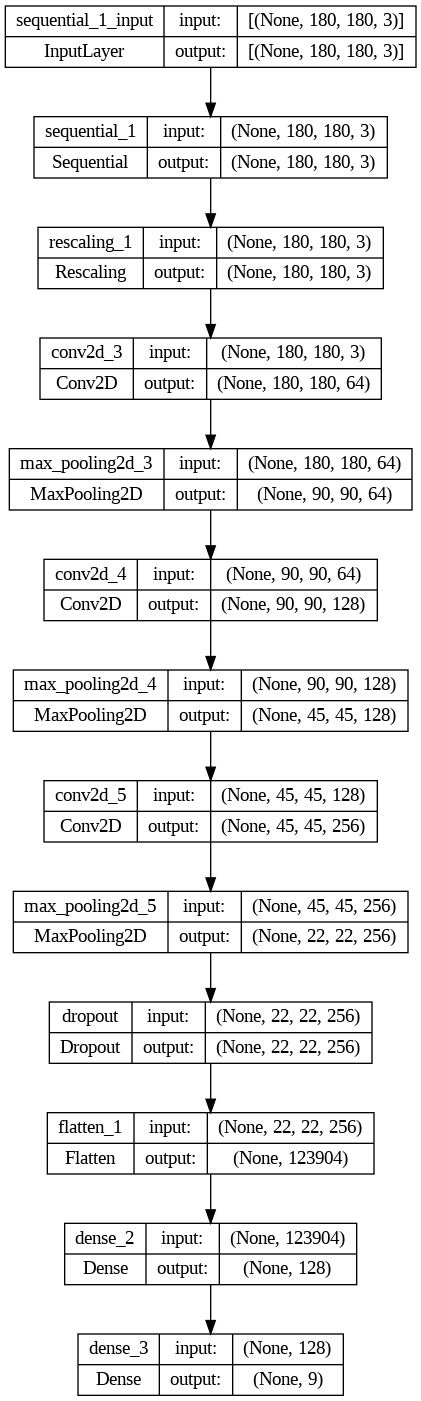

In [28]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 15s 207ms/step - loss: 2.3359 - accuracy: 0.2165 - val_loss: 1.9329 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 15s 262ms/step - loss: 1.9501 - accuracy: 0.2712 - val_loss: 1.8348 - val_accuracy: 0.2886
Epoch 3/20
56/56 [==============================] - 14s 248ms/step - loss: 1.7669 - accuracy: 0.3477 - val_loss: 1.6949 - val_accuracy: 0.3624
Epoch 4/20
56/56 [==============================] - 14s 247ms/step - loss: 1.7610 - accuracy: 0.3326 - val_loss: 1.7653 - val_accuracy: 0.3624
Epoch 5/20
56/56 [==============================] - 11s 195ms/step - loss: 1.6816 - accuracy: 0.3744 - val_loss: 1.6690 - val_accuracy: 0.3736
Epoch 6/20
56/56 [==============================] - 11s 192ms/step - loss: 1.6647 - accuracy: 0.3756 - val_loss: 1.5627 - val_accuracy: 0.4273
Epoch 7/20
56/56 [==============================] - 13s 234ms/step - loss: 1.5901 - accuracy: 0.4040 - val_loss: 2.2529 - val_accuracy: 0.3356
Epoch 8/20

### Visualizing the results

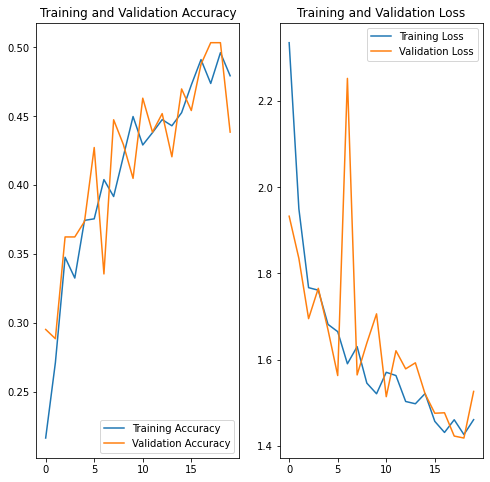

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Inference
###: *From the above we can infer that, the validation accuracy is catching up with training accuracy. But the overall accuracy is very less for both train and validation. This is a clear case of underfitting with 50% and 50% train and validation accuaracies respectively*



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
path_list=[]
label_list=[]
for i in class_names:  
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        label_list.append(i)
dataframe_dict_original = dict(zip(path_list, label_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df
     

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion


Class=actinic keratosis, Class_label=0, n=114 (5.092%)
Class=basal cell carcinoma, Class_label=1, n=376 (16.793%)
Class=dermatofibroma, Class_label=2, n=95 (4.243%)
Class=melanoma, Class_label=3, n=438 (19.562%)
Class=nevus, Class_label=4, n=357 (15.945%)
Class=pigmented benign keratosis, Class_label=5, n=462 (20.634%)
Class=seborrheic keratosis, Class_label=6, n=77 (3.439%)
Class=squamous cell carcinoma, Class_label=7, n=181 (8.084%)
Class=vascular lesion, Class_label=8, n=139 (6.208%)


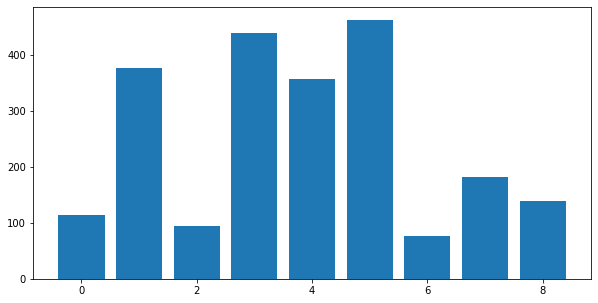

In [32]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# split into input and output elements
plt.figure(figsize=(10,5))
X, y = original_df['Path'], original_df['Label']

# label encode the target variable
y = LabelEncoder().fit_transform(y)


# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	  percent = v / len(y) * 100
	  print('Class=%s, Class_label=%d, n=%d (%.3f%%)' % (class_names[k], k, v, percent))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?


*   Seborrheic keratosis has the least number of samples


#### - Which classes dominate the data in terms proportionate number of samples?

*  Pigmented benign keratosis has the domination on the model as in terms of number of samples





#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAD301E5310>: 100%|██████████| 500/500 [00:20<00:00, 24.34 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAD3030EA30>: 100%|██████████| 500/500 [00:23<00:00, 21.17 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAD30225FD0>: 100%|██████████| 500/500 [00:18<00:00, 26.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FAD301490A0>: 100%|██████████| 500/500 [01:35<00:00,  5.24 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAD3057B460>: 100%|██████████| 500/500 [01:18<00:00,  6.38 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAD30103D00>: 100%|██████████| 500/500 [00:17<00:00, 28.20 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAD301E0EB0>: 100%|██████████| 500/500 [00:41<00:00, 12.14 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAD30322AC0>: 100%|██████████| 500/500 [00:17<00:00, 28.02 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAD30E04C40>: 100%|██████████| 500/500 [00:17<00:00, 28.03 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026650.jpg_fbc82a90-6995-41b5-bd58-bf20ecba9048.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_f5a47268-533b-4999-8623-e5d0a73a0a57.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027254.jpg_2a843b30-7dd6-474b-bbfc-501e2cfe71f2.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_e158d03a-192a-4041-a589-10f7aeae1f9d.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [38]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [40]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [45]:
new_df['Label'].value_counts().sum()

6739

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [47]:
data_dir_train=pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',  ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Autotuning

In [49]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [50]:
## your code goes here

classes_nums = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Convolution layer
model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
#Pooling Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. 
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
#Adding another Pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Third Convulation Layer
#Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
model.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Let us add some dropouts
model.add(layers.Dropout(0.25)),

#Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
##Flattens the input. Does not affect the batch size.
model.add(layers.Flatten())

#fully connected layer (Dense layer)
model.add(layers.Dense(128, activation="relu"))

# Output neuron
model.add(layers.Dense(classes_nums, activation='softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
     

#### **Todo:**  Train your model

In [52]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 35s 76ms/step - loss: 1.8922 - accuracy: 0.3062 - val_loss: 1.5224 - val_accuracy: 0.4410
Epoch 2/30
169/169 [==============================] - 7s 42ms/step - loss: 1.3922 - accuracy: 0.4776 - val_loss: 1.2700 - val_accuracy: 0.4996
Epoch 3/30
169/169 [==============================] - 7s 42ms/step - loss: 1.2106 - accuracy: 0.5527 - val_loss: 1.1452 - val_accuracy: 0.5694
Epoch 4/30
169/169 [==============================] - 7s 42ms/step - loss: 1.0981 - accuracy: 0.5935 - val_loss: 1.0099 - val_accuracy: 0.6303
Epoch 5/30
169/169 [==============================] - 7s 42ms/step - loss: 0.9001 - accuracy: 0.6743 - val_loss: 0.9294 - val_accuracy: 0.6585
Epoch 6/30
169/169 [==============================] - 7s 42ms/step - loss: 0.7904 - accuracy: 0.7144 - val_loss: 0.8335 - val_accuracy: 0.7112
Epoch 7/30
169/169 [==============================] - 7s 42ms/step - loss: 0.6725 - accuracy: 0.7619 - val_loss: 0.8114 - val_accuracy: 0.712

In [53]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

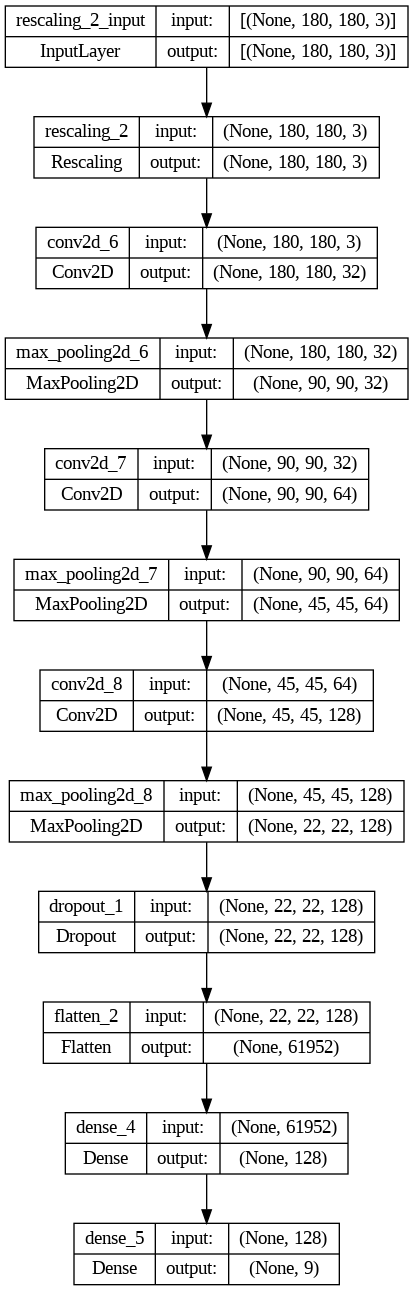

In [54]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### **Todo:**  Visualize the model results

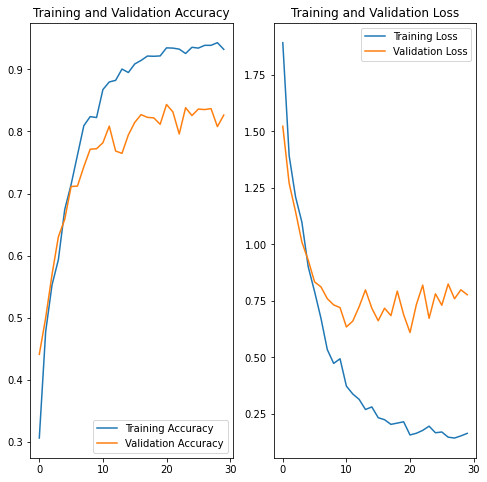

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes, it certainly helped.

# Inference:

### From the above model we can clearly say that the above model has eradicated both the overfitting and underfitting problem. The rebalance using Augementor Module balanced each classes by adding augmented image by a fixed amount (here 500). There by giving equal importance to all the input classes hence this model is a right fit with, 93% and 83% of accuracies of train and validation set respectively.



# MODEL PREDICTION

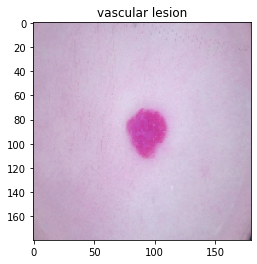

In [89]:
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[-1], '*')
Test_image = glob(Test_image_path) 
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.title(class_names[-1])
plt.grid(False)



In [90]:

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[-1] +'\n'+ "Predictive Class "+pred_class )

1/1 [==============================] - 0s 22ms/step
Actual Class vascular lesion
Predictive Class vascular lesion
